In [1]:
using Distributions, Optim, LinearAlgebra, Plots, StatsPlots
using CSV, DataFrames

In [2]:
# Import data
df = DataFrame(CSV.File("/Users/maishamaliha/Documents/BIOLOGY~VIP/nlcd_sage_beryl_1988.csv"))

,nlcd_sage_1988_mos_rec_v1,nlcd_sage_1989_mos_rec_v1,nlcd_sage_1990_mos_rec_v1
,Int64,Int64,Int64
1,0,5,8
2,0,5,8
3,0,5,8
4,0,5,8
5,0,5,8
6,0,5,8
7,0,5,8
8,0,5,8
9,0,5,8


In [3]:
dfn = Matrix{Int64}(df[1:30,:])

30×30 Matrix{Int64}:
 0  5  8  10   9  13  15  14  14  15  …  15  15  15  15  15  15  15  15  15
 0  5  8  10  12  13  17  16  17  17     17  17  17  17  17  17  17  17  17
 0  5  8  10  13  13  15  14  14  24     26  26  26  26  26  26  26  26  26
 0  5  8  10  13  15  14  15  15  24     26  26  26  26  26  26  26  26  26
 0  5  8   8   9  10  11  14  13  14     14  14  14  14  14  14  14  14  14
 0  5  8  10   9  15  18  18  17  18  …  18  18  18  18  18  18  18  18  18
 0  5  8  10  10  15  15  14  13  15     15  15  15  15  15  15  15  15  15
 0  5  8  10  11  13  14  13  14  18     18  18  18  18  18  18  18  18  18
 0  5  8  10  11  13  17  16  15  17     17  17  17  17  17  17  17  17  17
 0  5  8   9   8  15  17  17  16  15     13  17  17  17  17  17  17  17  17
 0  5  8   9   9  14  18  19  19  19  …  17  19  19  19  19  19  19  19  19
 0  5  6   5   9  10  12  12  11  12     12  12  11  12  12  12  12  12  12
 0  0  6   6   5  10  10  10  10  10      9  10  10  11  10  10  10

In [4]:
# reshape the data
Y = vec(dfn[:, 2:end])
X = vec(dfn[:, 1:end-1])
describe(Y)
Y = Y[X .> 0]
X = log.(X[X .> 0])

Summary Stats:
Length:         870
Missing Count:  0
Mean:           13.822989
Minimum:        0.000000
1st Quartile:   11.000000
Median:         14.000000
3rd Quartile:   17.000000
Maximum:        26.000000
Type:           Int64


836-element Vector{Float64}:
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 1.6094379124341003
 ⋮
 2.8903717578961645
 2.6390573296152584
 2.3978952727983707
 2.4849066497880004
 2.1972245773362196
 2.1972245773362196
 2.3978952727983707
 2.5649493574615367
 2.70805020110221
 2.302585092994046
 2.70805020110221
 3.1780538303479458

In [5]:
# define a simple Beverton-Holt (or some other growth) function
bh(x,p) = x .* (p[1] ./ (1 .+ x ./ p[2]))

# --- Point-estimate log-likelihood function
function loglike(rho)
    beta = rho[1:2]
    theta = exp.(bh(X, beta))
    dist = Poisson.(theta)
    lp = logpdf.(dist, Y)
    logl = sum(lp)
    return -logl
end

p0 = [1.1, 200] # initial parameter values
res = optimize(loglike, p0)
est = res.minimizer
# print estimated parameters
print(est)

[1.2029384404957382, 14.111539793344289]

In [6]:
# plot the original data and simulated trajectory
#  define the analytical solution for BH model
bht(t, p) = p[2]*p[3] ./ (p[3] .+ (p[2] - p[3]) * (p[1] .^-t) )

bht (generic function with 1 method)

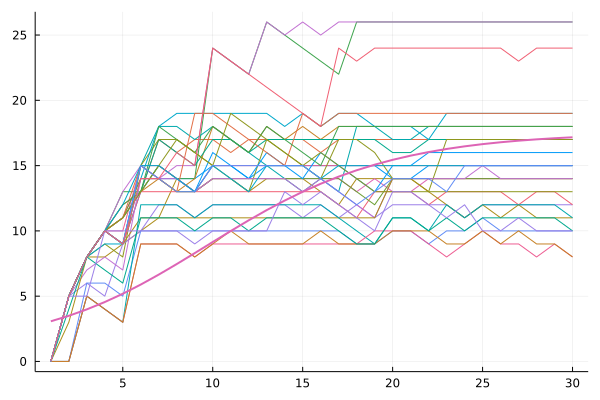

In [7]:
# set initial conditions and time array
n0 = 1.0
t = [1.0:1:30;]
# compute the carrying capacity
K = (est[1] - 1) * est[2]
# combine estimated parameters
phat = [est[1], K, n0]
# simulate and plot predicted cover
yhat = exp.(bht(t, phat)) #+ rand(Normal(0, est[3]), length(t))
plot(dfn', legend=:none)
plot!(t, yhat, linewidth=2, legend=:none)

In [8]:
# === add stage structure, no spatial dependence yet
# we can use the same framework, only now our function is a second-order autoregressive time series that accounts for 
Y = vec(dfn[:, 3:end])
X1 = vec(dfn[:, 2:end-1])
X2 = vec(dfn[:, 1:end-2])
# p = [R0, M, alpha]
function bhstage(X1, X2, p) 
    k = (p[1]-1)*p[2]
    return X1 .* (p[1] ./ (1 .+ X1 / p[2])) .+ p[3] .* (1.0 .- X1/k ) .* X2
end
p = [1.1, 100, .01]
bhstage(X1, X2, p)

840-element Vector{Float64}:
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  5.238095238095238
  0.0
  ⋮
 16.635661016949154
 13.452771929824562
 10.889900900900901
 11.761714285714286
  9.09056880733945
  9.09156880733945
 10.889900900900901
 12.615867256637172
 14.272826086956524
 10.0
 14.272826086956524
 20.954322580645165

In [9]:
# --- Point-estimate
function loglike(rho)
    beta = rho[1:3]
    sigma2 = exp(rho[4])
    residual = Y - bhstage(X1, X2, beta)
    dist = Normal(0, sqrt(sigma2))
    lp = logpdf.(dist, residual)
    logl = sum(lp)
    return -logl
end

loglike (generic function with 1 method)

In [10]:
# define positive constraints and initial parameters
lower = [0.0, 0, 0, 0]
upper = [Inf, Inf, Inf, Inf]
p0 = [1.1, 200, .1, .5] # initial values
# run optimization
res = optimize(loglike, lower, upper, p0)
est = res.minimizer
est[4] = exp(est[4])
# --- end

2.3350830623557406

In [52]:
import Pkg; Pkg.add("MCMCChains")
using Turing
using MCMCChains

import Pkg; Pkg.add("Turing")
# === Turing implementation
using Turing
n = length(Y)

@model poisson_regression(X1, Y, n) = begin
    b0 ~ truncated(Normal(0, 1), 0, Inf)
    b1 ~ truncated(Normal(0, 5), 0.01, Inf)

    for i = 1:n
        theta = X1[i] * (b0 / (1 + X1[i] / b1))
        Y[i] ~ Poisson(exp(theta))
    end
end;

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [49]:
import Pkg;Pkg.add("Random")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.6/Project.toml`
  No Changes to `~/.julia/environments/v1.6/Manifest.toml`


In [58]:
# Sample using NUTS.
using Random
Random.seed!(700)
num_chains = 4
m = poisson_regression(X1, Y, n)
chain = sample(m, NUTS(200, 0.65), MCMCThreads(), 500, num_chains; discard_adapt=true)

# sampler = NUTS(200, 0.65); chain = sample(m, sampler, MCMCThreads(), 500, num_chains; discard_adapt = true)

# Taking the first chain
c1 = chain[:,:,1]

# Calculating the exponentiated means
b0_exp = exp(mean(c1[:b0]))
b1_exp = exp(mean(c1[:b1]))

┌ Warning: Only a single thread available: MCMC chains are not sampled in parallel
└ @ AbstractMCMC /Users/maishamaliha/.julia/packages/AbstractMCMC/0eT8o/src/sample.jl:291
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/maishamaliha/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/maishamaliha/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /Users/maishamaliha/.julia/packages/AdvancedHMC/w90s5/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, true, true, false)
└ @ Advan

827.5055521527506

In [59]:
chain


Chains MCMC chain (500×14×4 Array{Float64, 3}):

Iterations        = 201:1:700
Number of chains  = 4
Samples per chain = 500
Wall duration     = 6.46 seconds
Compute duration  = 6.44 seconds
parameters        = b0, b1
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat   e ⋯
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64     ⋯

          b0    0.5990    0.0244     0.0005    0.0015   240.5942    1.0211     ⋯
          b1    6.6104    0.3879     0.0087    0.0241   229.1576    1.0223     ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

          b0

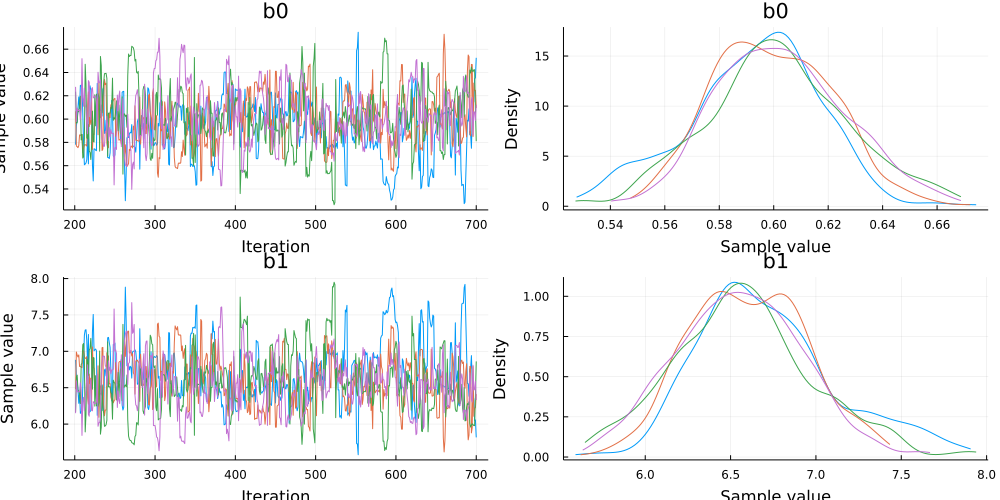

In [61]:
plot(chain)